In [45]:
from typing import Union
from tqdm import tqdm

import pandas as pd
import numpy as np

from scipy import stats
from statsmodels.stats.meta_analysis import effectsize_smd
from statsmodels.stats import proportion
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.power import zt_ind_solve_power
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [29]:
df = pd.read_excel('C:gb_sem_8_hm.xlsx')
df.head(10)

E:\Anaconda3\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [32]:
df.shape

(10000, 3)

In [33]:
df.describe() # срез по всему датасету

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [36]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [38]:
new_df = df[df['REVENUE']>0] # строки где выручка больше 0
new_df

,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
49,6429,control,3.25
139,3331,variant,4.27
149,8110,variant,1.75
152,8607,control,2.99
...,...,...,...
9651,9928,variant,1.25
9711,6468,control,2.93
9724,5205,control,14.17
9725,702,variant,2.92


In [39]:
new_df[df['VARIANT_NAME']=='variant'].describe()

C:\Users\Владимир\AppData\Local\Temp\ipykernel_5684\706561868.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_df[df['VARIANT_NAME']=='variant'].describe()


,USER_ID,REVENUE
count,72.000000,72.000000
mean,5306.958333,4.881528
std,3116.544256,9.913973
min,56.000000,0.020000
25%,2707.500000,1.245000
50%,5721.000000,2.170000
75%,7963.750000,3.972500
max,9996.000000,58.630000


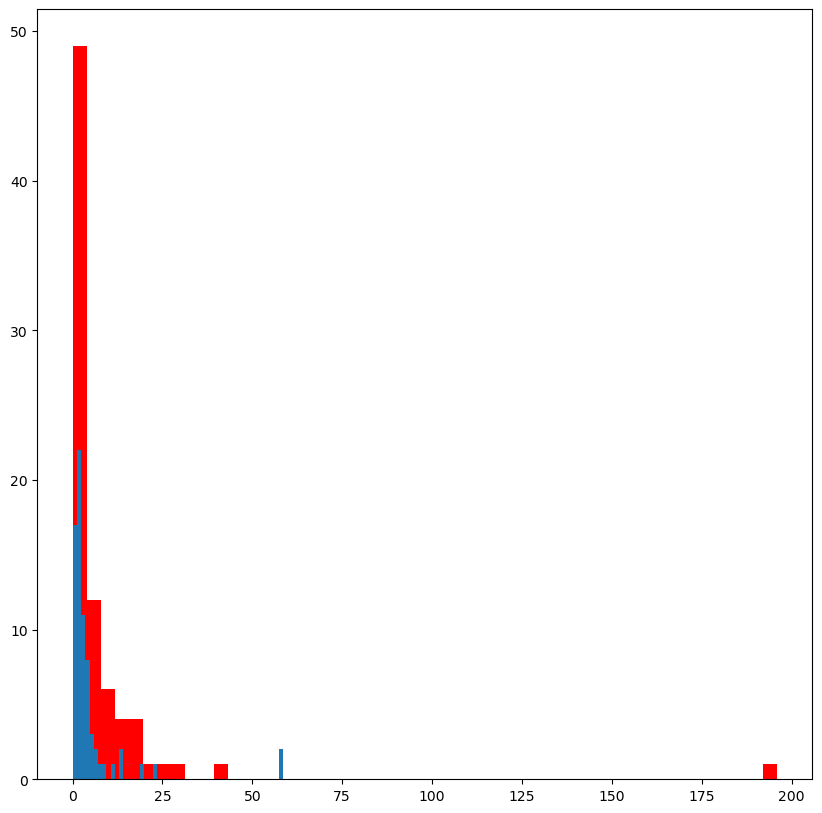

In [43]:
# График распределения
plt.figure(figsize=(10, 10))
control_visit_all = new_df['REVENUE'][df['VARIANT_NAME']=='control']
test_visit_all = new_df['REVENUE'][df['VARIANT_NAME']=='variant']

plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all, bins=50)

plt.show()

In [46]:
ttest_ind(control_visit_all, test_visit_all, equal_var = False)

Ttest_indResult(statistic=1.1379124979933528, pvalue=0.25760685398932337)

pvalue > 0.05
Значимых изменений нет.

In [47]:
# Проверка на нормальность тест Колмогорова-Смирнова
from scipy.stats import kstest
print(kstest(control_visit_all, 'norm'))
print(kstest(test_visit_all, 'norm'))

KstestResult(statistic=0.7443502263331446, pvalue=3.4769340937348253e-46)
KstestResult(statistic=0.6885669682907651, pvalue=1.5788521734348758e-34)


pvalue < 0.05
Отвергаем нулевую гипотезу данные распределенны не нормально.

In [48]:
# Расчет стататистики значимости Манна Уитни
from scipy.stats import mannwhitneyu
mannwhitneyu(control_visit_all, test_visit_all)

MannwhitneyuResult(statistic=3356.0, pvalue=0.07924299810603061)

pvalue > 0.05
Принимаем 0 гипотезу значемых изменений нет.

In [50]:
# Функция бутстрепа
from scipy.stats import norm

def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it = 1000,  # количество бутстрэп-подвыборок
    statistic = np.mean,  # интересующая нас статистика
    bootstrap_conf_level = 0.95  # уровень значимости
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
            ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
            ).values

        boot_data.append(statistic(samples_1)-statistic(samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    # значения квантилей
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('Значение метрики')
    plt.ylabel('Частота')
    plt.title("Гистограмма распределения")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1988.68it/s]


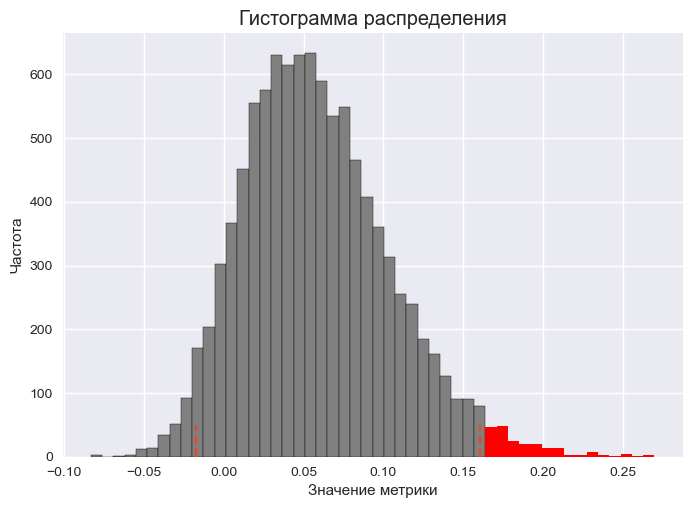

p_value 0.200276814066221


In [52]:
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.style.use('seaborn')
pd.options.display.float_format = '{:,.2f}'.format
# если 0 включен в доверительный интервал между группами нет разницы
# в результате хранится разница двух распределений, ДИ и pvalue
booted_df = get_bootstrap(df['REVENUE'][df['VARIANT_NAME']=='control'],
                            df['REVENUE'][df['VARIANT_NAME']=='variant'],
                            boot_it = 10000)

print('p_value', booted_df['p_value'])

p_value > 0.05
Нет статистической значимости.

Вывод: контрола больше раскатывать тест не нужно.